# Product Brief

* Необходимо подготовить несколько графиков/диаграмм/слайдов и пояснить их.
* Структурировать/категоризировать отзывы

In [1]:
!pip install wordcloud

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from pymystem3 import Mystem
import re
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score



from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier 

from wordcloud import WordCloud
from pandas import ExcelWriter
from tqdm import tqdm

# увеличиваю ширину колонок для чтения текста отзывов
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)

RND = 12345

In [3]:
# Загружаем датасет
data = pd.read_excel(r'D:\Data Science\Тестовые\deeray\Грибин Николай_Тестовое задание_отзывы.xlsx', sheet_name=1)

### Анализ данных

In [4]:
# формат datetime
data['Дата'] = pd.to_datetime(data['Дата'],  format='%d/%m/%Y')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3925 entries, 0 to 3924
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   ID отзыва                        3925 non-null   float64       
 1   Дата                             3925 non-null   datetime64[ns]
 2   Номенклатура                     3925 non-null   object        
 3   Количество звезд                 3925 non-null   int64         
 4   Бренд                            3925 non-null   object        
 5   Текст отзыва                     3925 non-null   object        
 6   Имя                              3925 non-null   object        
 7   Регион                           3925 non-null   object        
 8   Цвет                             2824 non-null   object        
 9   Размер                           3925 non-null   object        
 10  Полезность (количество минусов)  3925 non-null   int64      

In [6]:
data.isna().sum()

ID отзыва                             0
Дата                                  0
Номенклатура                          0
Количество звезд                      0
Бренд                                 0
Текст отзыва                          0
Имя                                   0
Регион                                0
Цвет                               1101
Размер                                0
Полезность (количество минусов)       0
Полезность (количество плюсов)        0
dtype: int64

In [7]:
data.duplicated().sum()

0

Пропуски есть в

In [8]:
data.sample(5)

,ID отзыва,Дата,Номенклатура,Количество звезд,Бренд,Текст отзыва,Имя,Регион,Цвет,Размер,Полезность (количество минусов),Полезность (количество плюсов)
2595,6729.0,2020-12-09,Артикул 1854,5,Бренд 24,"Упаковка порвана,но нитки в порядке",Любовь,RU,салатовый,0,0,0
827,2584.0,2021-05-19,Артикул 179,5,Бренд 22,Качественно обработанные детали рамы! Давно слышала о хорошем качестве Арабески. Решила попробовать. Спасибо произво...,Екатерина,RU,NaN,0,0,1
108,380.0,2021-10-20,Артикул 344,5,Бренд 21,"Немного разочаровал цвет, больше похоже на цвет алый чем на оранжевый.",Елена,RU,"морковный, оранжевый",0,0,0
3189,8176.0,2020-10-29,Артикул 347,5,Бренд 56,Супер 👍 Рекомендую,Гульзира,KZ,серебристый,0,0,1
3921,9994.0,2020-08-05,Артикул 475,5,Бренд 53,Пришел быстро. Не вскрытый. Брала за 1192 рубля. Дешевле чем в закупках вк.,Наталья,RU,горчичный,0,2,6


In [9]:
# содаю новые признаки
data['общая_полезность_разность'] = data['Полезность (количество плюсов)'] - data['Полезность (количество минусов)']
data['общая_полезность'] = data['Полезность (количество плюсов)'] + data['Полезность (количество минусов)']
data['полезность_pct'] =  (data['общая_полезность_разность'] / data['общая_полезность']) * 100

In [10]:
efficency = data.sort_values(by='общая_полезность_разность', ascending=False)

In [11]:
efficency.head(5)

,ID отзыва,Дата,Номенклатура,Количество звезд,Бренд,Текст отзыва,Имя,Регион,Цвет,Размер,Полезность (количество минусов),Полезность (количество плюсов),общая_полезность_разность,общая_полезность,полезность_pct
3086,7903.0,2020-11-07,Артикул 2725,5,Бренд 20,Отличная Пряжа. Вяжу из неё бактусы.,Наталья,RU,"черный, серый, желтый",0,2,121,119,123,96.747967
3817,9718.0,2020-08-20,Артикул 4246,5,Бренд 10,"Пряжа отличного качества, немного пружинит, при ВТО растягивается в два раза, но затем «приходит в себя» и увеличива...",Лариса,RU,глубокий фиолетовый,0,1,85,84,86,97.674419
3303,8457.0,2020-10-17,Артикул 3761,5,Бренд 10,"Я в восторге от этой пряжи! Мягкая, теплая, не колючая) \nНа кофточку 46 размера ушло ровно 6 мотков. Вязала спицами...",Яна,RU,светло-зеленый,0,0,81,81,81,100.000000
3662,9320.0,2020-09-10,Артикул 3094,5,Бренд 18,"Прекрасная пряжа. По моим ощущениям есть пропитка, т.к. после вто пряжа преображается - становится пушистее и ещё мя...",Ксения,RU,"желтый, светло-бирюзовый, голубой",0,1,81,80,82,97.560976
3181,8155.0,2020-10-29,Артикул 4488,5,Бренд 10,"Шикарная ниточка, пока расход мизерный",Татьяна,RU,светло-серый,0,0,77,77,77,100.000000


In [12]:
efficency.tail(5)

,ID отзыва,Дата,Номенклатура,Количество звезд,Бренд,Текст отзыва,Имя,Регион,Цвет,Размер,Полезность (количество минусов),Полезность (количество плюсов),общая_полезность_разность,общая_полезность,полезность_pct
1989,5308.0,2021-01-19,Артикул 2021,1,Бренд 2,Ну и.забрала набор и не посмотрела..а дома смотрю.а рисунка на канве НЕТ.и что. вышивать счетным крестом..которым я ...,Оксана,RU,белый,0,12,0,-12,12,-100.000000
2700,6963.0,2020-12-01,Артикул 2047,4,Бренд 10,"К сожалению альпака оказалась очень колючей для кожи с атопическим дерматитом. И конечно же минус в том, что нельзя ...",Анастасия,RU,фуксия,0,28,14,-14,42,-33.333333
3053,7818.0,2020-11-09,Артикул 1776,2,Бренд 4,Получила набор.Был вскрыт и даже ничем не заклеен.Все из него вываливалось.В наборе не хватало ключа(расшифровки сим...,Надежда,RU,NaN,0,17,1,-16,18,-88.888889
3033,7770.0,2020-11-10,Артикул 3032,5,Бренд 10,Вязала сыну пуловер. Классные нитки. Вязать очень приятно. Не колется. Спасибо.,Татьяна,RU,аметистовый,0,35,14,-21,49,-42.857143
3154,8087.0,2020-11-01,Артикул 1776,1,Бренд 4,"Заказала набор luca s, получила в пункте выдачи, при проверке данного набора было обнаружено отсутствие расшифровки ...",Наталья,RU,NaN,0,28,2,-26,30,-86.666667


In [13]:
# график

### Топ брендов

In [14]:
efficency.groupby('Бренд')['общая_полезность_разность'].agg(['count', 'sum']).sort_values(by='sum', ascending=False)

,count,sum
Бренд,,
Бренд 10,706,4367
Бренд 18,224,816
Бренд 24,531,751
Бренд 16,84,463
Бренд 22,270,394
Бренд 21,115,377
Бренд 4,135,253
Бренд 2,286,246
Бренд 53,88,222


### Топ артикулов

In [15]:
efficency.groupby('Номенклатура')['общая_полезность_разность'].agg(['count', 'sum']).sort_values(by='count', ascending=False)

,count,sum
Номенклатура,,
Артикул 64,87,28
Артикул 347,69,120
Артикул 752,67,71
Артикул 217,31,46
Артикул 385,26,26
...,...,...
Артикул 3246,3,0
Артикул 1954,3,9
Артикул 3242,3,8


### Количество звезд у коментариев

In [16]:
number_stars = pd.DataFrame(data.groupby('Количество звезд')['Текст отзыва'].agg('count'))
number_stars.columns = ['Количество']
number_stars

,Количество
Количество звезд,
1,249
2,96
3,166
4,296
5,3118


## Top20 отзывов

In [17]:
top20 = data['Номенклатура'].value_counts().sort_values(ascending=False).head(20)

In [18]:
top20

Артикул 64      87
Артикул 347     69
Артикул 752     67
Артикул 217     31
Артикул 385     26
Артикул 697     25
Артикул 31      21
Артикул 28      20
Артикул 693     18
Артикул 378     17
Артикул 1377    16
Артикул 288     15
Артикул 1415    15
Артикул 1229    14
Артикул 451     14
Артикул 320     14
Артикул 237     13
Артикул 903     12
Артикул 419     12
Артикул 84      11
Name: Номенклатура, dtype: int64

In [19]:
data.loc[top20]['Текст отзыва']

87                                                                                Очень хороший, станочек! У меня уже второй!
69                                                                                                     Спасибо производителю!
67                                                   Отличная пряжа! Без узелков, все как всегда в ней, полностью устраивает!
31    очень расстроена, ножки-основания не подходят друг другу по толщине, как писала выше девушка, тот же брак.\nпридется...
26    Пряжа хорошая. Но после ручной стирки связанное изделие очень сильно растягивается. Чтобы осталось нужного размера н...
25    Увидела этот продукт в инстаграме магазина почитала отзывы и решила заказать. Все пришло хорошо запакованное целое, ...
21                                           Очень качественное изделие, аккуратно исполнены все детали, прочное и устойчивое
20    Вышивка не плохая, бисер не самого высокого качества, но смотрится не плохо. Снимаю одну звезду за то что не хва

In [20]:
data['Текст отзыва'] = data['Текст отзыва'].str.replace('\n', ' ')

### Создаем новые признаки длина комментариев и кол-во слов

In [21]:
data['первый_отзыв'] = data. \
            groupby('ID отзыва')['Дата'].transform('min')

In [22]:
data

,ID отзыва,Дата,Номенклатура,Количество звезд,Бренд,Текст отзыва,Имя,Регион,Цвет,Размер,Полезность (количество минусов),Полезность (количество плюсов),общая_полезность_разность,общая_полезность,полезность_pct,первый_отзыв
0,4.0,2021-11-06,Артикул 4,5,Бренд 4,"Полный комплект, ниток достаточно, много осталось, вышивается легко, рекомендую к покупке. Добавлю фото других набор...",Ирина,RU,NaN,0,0,0,0,0,NaN,2021-11-06
1,7.0,2021-11-06,Артикул 7,5,Бренд 6,"Очень понравился набор! Бисер качественный, остается много! Рекомендую!",Наталья,RU,белый,0,0,0,0,0,NaN,2021-11-06
2,8.0,2021-11-06,Артикул 8,5,Бренд 6,Очень красиво получилось,Наталья,RU,синий,0,0,0,0,0,NaN,2021-11-06
3,21.0,2021-11-05,Артикул 21,5,Бренд 2,"Набор полный, целый, восхитительный! Открываешь коробочку, а в ней солнце, тепло, блеск, игра бисера! Превосходный н...",Маргарита,RU,белый,0,0,0,0,0,NaN,2021-11-05
4,23.0,2021-11-05,Артикул 23,5,Бренд 14,"Заказывала серый сероголубой, пришел синий васильковый, даже не распаковала., отказ, жаль потраченное время.",Ирина,RU,"серо-голубой, голубой",0,0,0,0,0,NaN,2021-11-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3920,9993.0,2020-08-05,Артикул 3108,5,Бренд 10,"Цвет не серо -голубой,а ближе к серо -зеленому .",Ирина,RU,серо-голубой,0,1,3,2,4,50.0,2020-08-05
3921,9994.0,2020-08-05,Артикул 475,5,Бренд 53,Пришел быстро. Не вскрытый. Брала за 1192 рубля. Дешевле чем в закупках вк.,Наталья,RU,горчичный,0,2,6,4,8,50.0,2020-08-05
3922,9995.0,2020-08-05,Артикул 3388,5,Бренд 10,"Цвет немного отличается, больше с фиолетовым оттенком, плюс белые шерстинки придают более бледный вид. А так пряжа м...",Инна,RU,пурпурный,0,0,6,6,6,100.0,2020-08-05
3923,9998.0,2020-08-04,Артикул 879,5,Бренд 8,Класс очень красиво,Елена,RU,белый,0,0,0,0,0,NaN,2020-08-04


In [23]:
def words_count(text):
    result = len(text.split())
    return result

In [24]:
data['words_count'] = data['Текст отзыва'].apply(words_count)

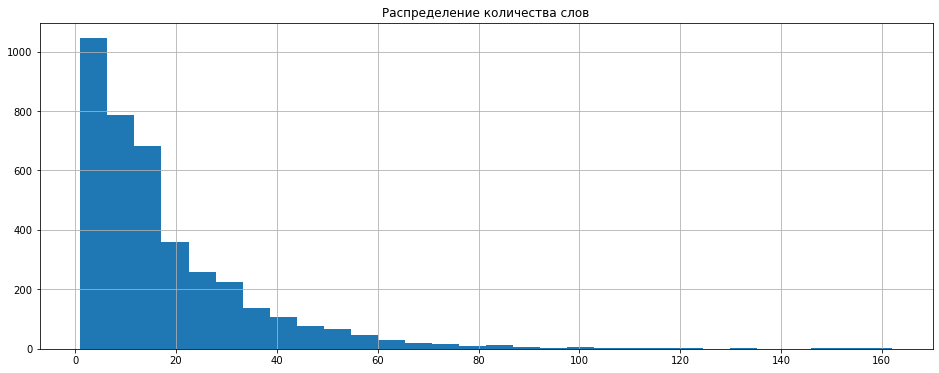

In [25]:
data['words_count'].hist(bins=30, figsize=(16,6))
plt.title('Распределение количества слов')
plt.show()

In [26]:
data = data.sort_values(by='первый_отзыв', ascending=True)

<AxesSubplot:xlabel='первый_отзыв'>

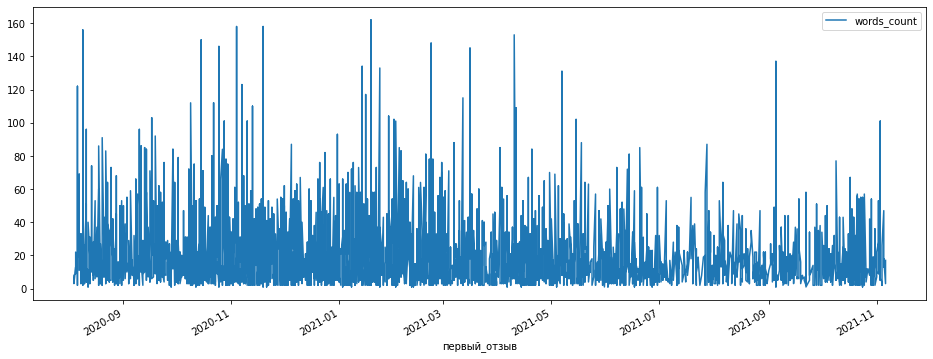

In [27]:
data.plot(kind='line', x='первый_отзыв', y='words_count', figsize=(16,6))

<AxesSubplot:>

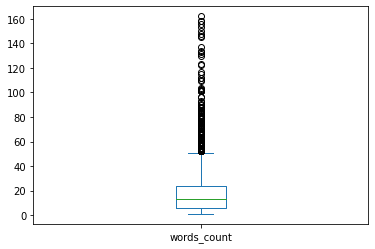

In [28]:
data['words_count'].plot(kind='box')

In [29]:
data[data['words_count'] > 60]['Текст отзыва']

3919    Вышивается очень быстро! Фото не передает всего великолепия готовой работы. Икона светится изнутри , переливается и ...
3910    Я новичок в вязании, поэтому что-то серьезнее шарфиков мне пока страшно начинать. Пряжа сперва понравилась по цвету,...
3898    Пишу спустя неделю после покупки. Это мой первый опыт работы с бисером, поначалу была  шоке, но глаза боятся, а руки...
3879    Позорище! Больше никак не могу охарактеризовать данный набор. Откуда такая цена? За кусочек ткани с нанесенным ликом...
3855    И я присоединюсь к довольным покупателям. Пряжу просто из рук не хочется выпускать. Заказала 2 цвета - изумруд и сер...
                                                                 ...                                                           
460     В целом хорошая рама, клипсы держатся хуже, чем на раме, купленной 4 года назад со станком Иволга. Не знаю, с чем св...
332     Потрясающая пряжа. Приехал полный комплект, аккуратно упакован в зип-лок и дополнительно заклеен

In [30]:
def findLen(str):
    counter = 0
    while str[counter:]:
        counter += 1
    return counter

In [31]:
data['lenght_com'] = data['Текст отзыва'].apply(findLen)

<AxesSubplot:>

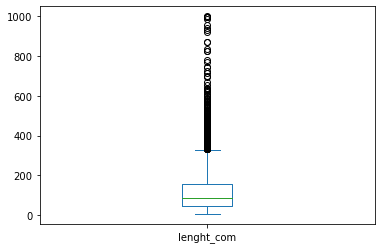

In [32]:
data['lenght_com'].plot(kind='box')


In [33]:
data[data['lenght_com'] > 400]['Текст отзыва']

3919    Вышивается очень быстро! Фото не передает всего великолепия готовой работы. Икона светится изнутри , переливается и ...
3910    Я новичок в вязании, поэтому что-то серьезнее шарфиков мне пока страшно начинать. Пряжа сперва понравилась по цвету,...
3898    Пишу спустя неделю после покупки. Это мой первый опыт работы с бисером, поначалу была  шоке, но глаза боятся, а руки...
3879    Позорище! Больше никак не могу охарактеризовать данный набор. Откуда такая цена? За кусочек ткани с нанесенным ликом...
3855    И я присоединюсь к довольным покупателям. Пряжу просто из рук не хочется выпускать. Заказала 2 цвета - изумруд и сер...
                                                                 ...                                                           
258     Получила приправу 22.09.2021г, вскрыла упаковку и только потом посмотрела на срок годности😞дата изготовления 25.12.2...
173     "Серёга, ты реально - МАСТЕР"!  Собрала без чьей либо помощи за 10 минут. Просто потому, что пол

In [34]:
data[data['Текст отзыва'].str.contains("возврат")]['Текст отзыва']

3861    Заказала набор. В итоге пришёл бисер, но без холста. Оформила возврат по браку, заявку одобрили. Деньги вернули. Спа...
3779                                                                   Вместо розового пришёл какой то красный поэтому возврат!
3698    Заказала 4 упаковки этой пряжи. Пришла получать. Три упаковки по 3 моточка, как и положено, а в 4 всего один моточек...
3624    Добрый день!  Он изумительный! Не очень тонкий, но уже каменного. Все грани ровные, удобный, форма идеальная. До это...
3572    Заказала 7 комплектов по 3 шт. В итоге пришли 5 комплектов пришли из одной партии, оставшиеся 2 пришли ещё из двух р...
                                                                 ...                                                           
195                                                   пришел товар другого цвета, жду одобрения возврата,а это время и ожидание
134     Пришла партия другого цвета, которая дешевле заказанной, но деньги взяли как за более дорогой то

In [35]:
data[data['Текст отзыва'].str.contains("качество")]['Текст отзыва']

3905    Я довольна качеством! Был раньше из оникса и разбился, решила купить не убиваемый. Он немного точне и массаж получае...
3793                                                                            Отличное качество. Цвет полностью соответствует
3783    Из натуральных камней только гематит размером с бисер. Вышивается легко, все понятно. Упакован набор в подарочный па...
3759                                                                               Спасибо производителю за качество и красоту!
3742    Пряжа супер, мягкая, лёгкая, не колючая,без узелков, слабый запах шерсти присутствует. Второе фото, с официального с...
                                                                 ...                                                           
186                                                                Отличное качество и приемлемая цена.Рекомендую рукодельницам
173     "Серёга, ты реально - МАСТЕР"!  Собрала без чьей либо помощи за 10 минут. Просто потому, что пол

In [36]:
data['Размер'] = data['Размер'].str.lower().value_counts()

In [37]:
data.corr().style.highlight_between(left=0.5, right=1, color='yellowgreen').highlight_null(null_color='lightgrey').highlight_max(color='coral')

,ID отзыва,Количество звезд,Размер,Полезность (количество минусов),Полезность (количество плюсов),общая_полезность_разность,общая_полезность,полезность_pct,words_count,lenght_com
ID отзыва,1.000000,-0.001664,nan,0.107201,0.213130,0.193319,0.225080,0.027821,0.084295,0.081867
Количество звезд,-0.001664,1.000000,nan,-0.201951,0.090309,0.128501,0.050504,0.330338,-0.095841,-0.084364
Размер,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Полезность (количество минусов),0.107201,-0.201951,nan,1.000000,0.103394,-0.084747,0.281139,-0.483807,0.074101,0.067666
Полезность (количество плюсов),0.213130,0.090309,nan,0.103394,1.000000,0.982300,0.983592,0.190522,0.215234,0.206714
общая_полезность_разность,0.193319,0.128501,nan,-0.084747,0.982300,1.000000,0.932389,0.280981,0.201660,0.194337
общая_полезность,0.225080,0.050504,nan,0.281139,0.983592,0.932389,1.000000,0.094487,0.221106,0.211719
полезность_pct,0.027821,0.330338,nan,-0.483807,0.190522,0.280981,0.094487,1.000000,0.098561,0.107496
words_count,0.084295,-0.095841,nan,0.074101,0.215234,0.201660,0.221106,0.098561,1.000000,0.990991
lenght_com,0.081867,-0.084364,nan,0.067666,0.206714,0.194337,0.211719,0.107496,0.990991,1.000000


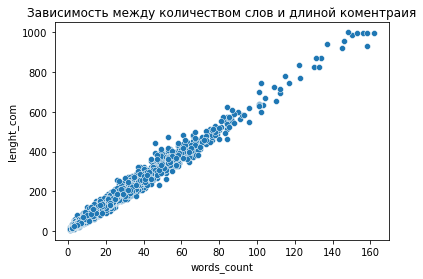

In [38]:
sns.scatterplot(data=data, x="words_count", y="lenght_com")
plt.title('Зависимость между количеством слов и длиной коментраия')
plt.show()

Пока оставлю, но при обучении модели вожмоно стоит пересмотреть признаки

### Категоризация данных

In [39]:
# Тип комментария
def сom_type(x):
    if x == 5: 
        return 'Супер'
    elif x == 4:
        return 'Хороший'
    else:
        return 'Плохо'

In [40]:
data['сom_type'] = data['Количество звезд'].apply(сom_type)

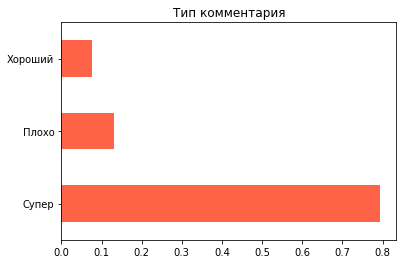

In [41]:
data['сom_type'].value_counts(normalize=True).plot(kind='barh', color='tomato')
plt.title('Тип комментария')
plt.show()

In [42]:
def categorize_purpose(row):
    try:
        if 'возврат' in row:
            return 'возврат'
        elif 'цена' in row or 'дорого' in row:
            return 'не устраивает цена'
        elif 'качество' in row or 'расстроен' in row:
            return 'не устраивает качество'
        elif 'комплект' in row or 'вместо' in row or 'вскрытый' in row:
            return 'не полная комплектность'
        elif 'цвет' in row and data['сom_type'] == 'Плохо':
            return 'другой цвет'
    except:
        return 'нет категории'

In [43]:
bad_comments = data[data['сom_type'] == 'Плохо']

In [44]:
data['причина'] = bad_comments['Текст отзыва'].apply(categorize_purpose)

In [45]:

data['причина'] = data['причина'].fillna('нет жалоб')

In [46]:
data['причина'].value_counts(normalize=True)

нет жалоб                  0.944204
не полная комплектность    0.018599
нет категории              0.018599
возврат                    0.011465
не устраивает качество     0.004076
не устраивает цена         0.003057
Name: причина, dtype: float64

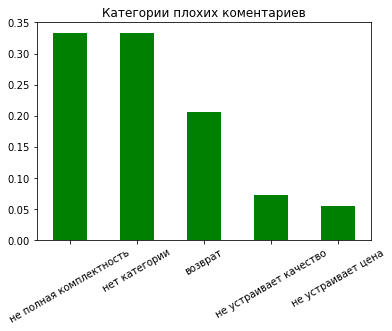

In [47]:
# убрал 'нет жадоб' для отоброжения категорий
data[data['причина'] != 'нет жалоб']['причина'].value_counts(normalize=True).plot(kind='bar', color='green')
plt.title('Категории плохих коментариев')
plt.xticks(rotation=30)
plt.show()

In [48]:
data.head(5)

,ID отзыва,Дата,Номенклатура,Количество звезд,Бренд,Текст отзыва,Имя,Регион,Цвет,Размер,Полезность (количество минусов),Полезность (количество плюсов),общая_полезность_разность,общая_полезность,полезность_pct,первый_отзыв,words_count,lenght_com,сom_type,причина
3924,9999.0,2020-08-04,Артикул 879,5,Бренд 8,"Просто супер, очень красивая вышивка, буду еще заказывать",Елена,RU,белый,NaN,0,0,0,0,NaN,2020-08-04,8,57,Супер,нет жалоб
3923,9998.0,2020-08-04,Артикул 879,5,Бренд 8,Класс очень красиво,Елена,RU,белый,NaN,0,0,0,0,NaN,2020-08-04,3,19,Супер,нет жалоб
3921,9994.0,2020-08-05,Артикул 475,5,Бренд 53,Пришел быстро. Не вскрытый. Брала за 1192 рубля. Дешевле чем в закупках вк.,Наталья,RU,горчичный,NaN,2,6,4,8,50.0,2020-08-05,13,75,Супер,нет жалоб
3920,9993.0,2020-08-05,Артикул 3108,5,Бренд 10,"Цвет не серо -голубой,а ближе к серо -зеленому .",Ирина,RU,серо-голубой,NaN,1,3,2,4,50.0,2020-08-05,9,48,Супер,нет жалоб
3922,9995.0,2020-08-05,Артикул 3388,5,Бренд 10,"Цвет немного отличается, больше с фиолетовым оттенком, плюс белые шерстинки придают более бледный вид. А так пряжа м...",Инна,RU,пурпурный,NaN,0,6,6,6,100.0,2020-08-05,22,149,Супер,нет жалоб


### Gender

In [49]:
# так как имена есть и на английском, учитываем это
def categorize_gender(data):
    mask = data['Имя'].str.endswith('a') | data['Имя'].str.endswith('я') | data['Имя'].str.endswith('а') | data['Имя'].str.endswith('ь')  
    data['Gender'] = 'Мужской'
    data.loc[mask, 'Gender'] = 'Женский'
    return data


In [50]:
data = categorize_gender(data)


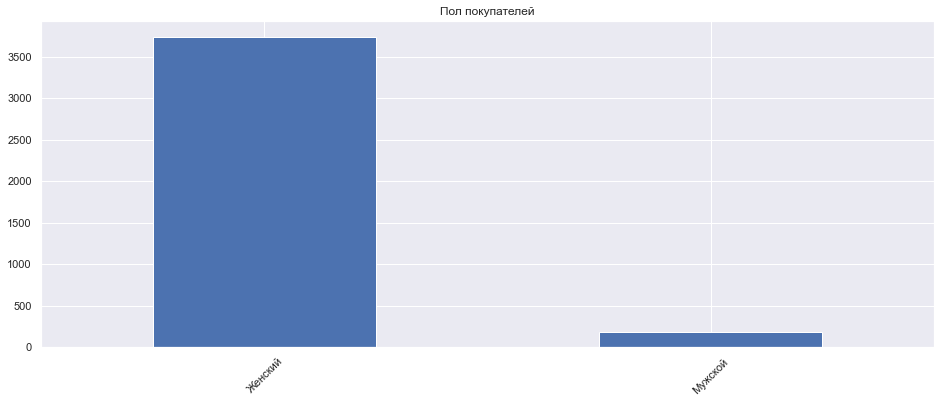

In [77]:
data['Gender'].value_counts().plot(kind='bar')
plt.title('Пол покупателей')
plt.xticks(rotation=45)
plt.show()

In [52]:
data[['общая_полезность', 'полезность_pct', 'Полезность (количество минусов)', 'Полезность (количество плюсов)']].sort_values(by='общая_полезность', ascending=False)

,общая_полезность,полезность_pct,Полезность (количество минусов),Полезность (количество плюсов)
3086,123,96.747967,2,121
3817,86,97.674419,1,85
3662,82,97.560976,1,81
3303,81,100.000000,0,81
3181,77,100.000000,0,77
...,...,...,...,...
1835,0,NaN,0,0
1832,0,NaN,0,0
1827,0,NaN,0,0
1852,0,NaN,0,0


In [53]:
def categorize_values(values):
    categories = ['E', 'D', 'C','B','A']
    cutoffs = [20, 40, 60, 80, 125]
    categories_dict = dict(zip(range(len(categories)), categories))
    categories_dict[len(categories_dict)] = 'другая'
    result = []
    for value in values:
        if value < 0 or value > 140:
            result.append(None)
        else:
            for i, cutoff in enumerate(cutoffs):
                if value <= cutoff:
                    result.append(categories_dict[i])
                    break
            else:
                result.append(categories_dict[len(categories_dict) - 1])
    return result


In [54]:
data['категория_полезности'] = categorize_values(data['общая_полезность'])


In [55]:
data[['общая_полезность', 'категория_полезности', 'полезность_pct', 'Полезность (количество минусов)', 'Полезность (количество плюсов)']].sort_values(by='общая_полезность', ascending=False)

,общая_полезность,категория_полезности,полезность_pct,Полезность (количество минусов),Полезность (количество плюсов)
3086,123,A,96.747967,2,121
3817,86,A,97.674419,1,85
3662,82,A,97.560976,1,81
3303,81,A,100.000000,0,81
3181,77,B,100.000000,0,77
...,...,...,...,...,...
1835,0,E,NaN,0,0
1832,0,E,NaN,0,0
1827,0,E,NaN,0,0
1852,0,E,NaN,0,0


In [56]:
data['категория_полезности'].value_counts()

E    3798
D      91
C      22
B      10
A       4
Name: категория_полезности, dtype: int64

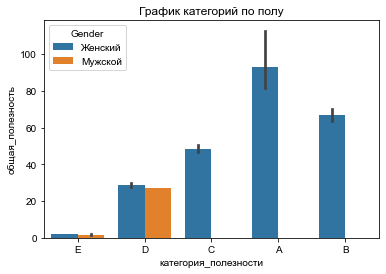

In [57]:
sns.barplot(data=data, x='категория_полезности', y='общая_полезность', hue="Gender")
sns.set(rc={'figure.figsize':(16,6)})
plt.title('График категорий по полу')
plt.show()

In [58]:
data[data['Gender'] == 'Мужской']

,ID отзыва,Дата,Номенклатура,Количество звезд,Бренд,Текст отзыва,Имя,Регион,Цвет,Размер,...,общая_полезность_разность,общая_полезность,полезность_pct,первый_отзыв,words_count,lenght_com,сom_type,причина,Gender,категория_полезности
3900,9948.0,2020-08-08,Артикул 646,5,Бренд 21,"Спасибо, все отлично!!!",Борис,RU,синий,NaN,...,0,0,NaN,2020-08-08,3,23,Супер,нет жалоб,Мужской,E
3802,9680.0,2020-08-22,Артикул 4602,5,Бренд 10,Отлично Спасибо большое,Заур,KZ,золотистый,NaN,...,-1,5,-20.000000,2020-08-22,3,23,Супер,нет жалоб,Мужской,E
3746,9543.0,2020-08-29,Артикул 3777,5,Бренд 10,Жена просто в восторге. Спасибо огромное👍🏻,Петр,RU,коричневый,NaN,...,4,4,100.000000,2020-08-29,6,42,Супер,нет жалоб,Мужской,E
3694,9400.0,2020-09-06,Артикул 3604,3,Бренд 10,На фото явно добавили Цветности или Яркого освещения. Цвет в реальности ТЕМНЕЕ. Запах очень приятный и вкусный)..,Евгени,RU,светло-серый,NaN,...,1,3,33.333333,2020-09-06,17,114,Плохо,нет жалоб,Мужской,E
3683,9373.0,2020-09-08,Артикул 347,5,Бренд 56,Роскошный малыш :),Алсу,RU,серебристый,NaN,...,3,3,100.000000,2020-09-08,3,18,Супер,нет жалоб,Мужской,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,148.0,2021-10-30,Артикул 53,5,Бренд 24,Отличные ниточки. А цена вообще сказочная. Спасибо.,Руслан,RU,NaN,NaN,...,0,0,NaN,2021-10-30,7,51,Супер,нет жалоб,Мужской,E
32,127.0,2021-10-31,Артикул 123,5,Бренд 3,Отличная канва!!!,Андрей,RU,слоновая кость,NaN,...,0,0,NaN,2021-10-31,2,17,Супер,нет жалоб,Мужской,E
21,83.0,2021-11-02,Артикул 48,5,Бренд 22,"Очень качественное изделие, аккуратно исполнены все детали, прочное и устойчивое",Александр,RU,NaN,NaN,...,0,0,NaN,2021-11-02,10,80,Супер,нет жалоб,Мужской,E
17,66.0,2021-11-03,Артикул 64,5,Бренд 25,Супер! Доставка быстрая! Супруга довольна.,Максим,KZ,NaN,NaN,...,0,0,NaN,2021-11-03,5,42,Супер,нет жалоб,Мужской,E


In [59]:
writer = ExcelWriter('Finaldata.xlsx')
data.to_excel(writer,'Sheet1', index=False)
writer.save()

#### Вывод

* Оставляют комментарии женщины, но и тематика вышивка, однако есть и мужчины покупающие товары для вторых половинок. 

### NLP обучение моделей

In [60]:
# задаем позитивную целевую переменную
def target(x):
    if x == 'Супер':
        return 1
    else:
        return 0

data['target'] = data['сom_type'].apply(target)

In [61]:
corpus = list(data['Текст отзыва'])

In [62]:
# лемантизируем слова
def lemmatize(text):
    m = Mystem()
    lemm_list = m.lemmatize(text)
    lemm_text = "".join(lemm_list)
        
    return lemm_text

# очищаем слова
def clear_text(text):
    clear = re.sub(r'[^а-яА-ЯёЁ]', ' ', text)
    сlear = clear.split()
    clear = ''.join(clear)
    return clear

print("Исходный текст:", corpus[0])
print("Очищенный и лемматизированный текст:", lemmatize(clear_text(corpus[0])))

Исходный текст: Просто супер, очень красивая вышивка, буду еще заказывать
Очищенный и лемматизированный текст: просто супер  очень красивый вышивка  быть еще заказывать



In [63]:
%%time

tqdm.pandas()

data['Текст отзыва'] = data['Текст отзыва'].progress_apply(clear_text).progress_apply(lemmatize)


100%|██████████| 3925/3925 [54:16<00:00,  1.21it/s]

CPU times: total: 11.2 s
Wall time: 54min 16s


CPU times: total: 10.8 s
Wall time: 53min 53s

In [64]:
count_vect = CountVectorizer(ngram_range=(2, 2)) 
n_gramm = count_vect.fit_transform(corpus)
print("Размер:", n_gramm.shape)

Размер: (3925, 43391)


In [65]:
corpus = data['Текст отзыва'].values.astype('U')

nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('russian'))



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\theli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Обучение модели

In [66]:
features = data.drop('target', axis=1)
target = data['target']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, stratify=target, random_state=RND)

In [68]:
%%time

lr_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stopwords)),
    ('clf', LogisticRegression(random_state=RND))])

params = {'clf__C': [0.1, 1, 10, 100],
          'clf__class_weight': ['balanced']}

lr_grid = GridSearchCV(estimator=lr_pipe,
                       param_grid=params,
                       cv=3, scoring='f1',
                       n_jobs=-1,
                       refit=False
                      
                      )

lr_grid.fit(X_train['Текст отзыва'], y_train)


print('Лучшие параметры', lr_grid.best_params_)
print('Лучшая метрика', lr_grid.best_score_)

Лучшие параметры {'clf__C': 10, 'clf__class_weight': 'balanced'}
Лучшая метрика 0.9121545129713068
CPU times: total: 78.1 ms
Wall time: 4.44 s


Лучшие параметры {'clf__C': 10, 'clf__class_weight': 'balanced'}

Лучшая метрика 0.9121545129713068

CPU times: total: 31.2 ms

Wall time: 359 ms

In [69]:
%%time

lgb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stopwords)),
    ('clf', LGBMClassifier(random_state=RND))])

params = {
  'clf__n_estimators': [150],
  'clf__learning_rate': [0.15, 0.25],
  'clf__max_depth': [8, 10, -1]}

lgb_grid = GridSearchCV(estimator=lgb_pipe, 
                        param_grid=params, 
                        cv=3, scoring='f1',
                        n_jobs=-1,
                        refit=False
                       )
lgb_grid.fit(X_train['Текст отзыва'], y_train)
lgb_best_params = lgb_grid.best_params_

print('Лучшие параметры', lgb_best_params)
print('Лучшая метрика', lgb_grid.best_score_)

Лучшие параметры {'clf__learning_rate': 0.15, 'clf__max_depth': 8, 'clf__n_estimators': 150}
Лучшая метрика 0.9012098903420737
CPU times: total: 109 ms
Wall time: 2.68 s


Лучшие параметры {'clf__learning_rate': 0.15, 'clf__max_depth': 8, 'clf__n_estimators': 150}

Лучшая метрика 0.9012098903420737

CPU times: total: 125 ms

Wall time: 2.61 s

### Тестирование модели

In [70]:
count_tf_idf = TfidfVectorizer(ngram_range=(1,3),
                                min_df=3, 
                                max_df=0.9, 
                                use_idf=1,
                                smooth_idf=1, 
                                sublinear_tf=1, 
                                stop_words=stopwords
                           )

In [71]:

X_train = count_tf_idf.fit_transform(X_train['Текст отзыва'])
X_test = count_tf_idf.transform(X_test['Текст отзыва'])

print("Размер матрицы:", X_train.shape)
print("Размер матрицы:", X_test.shape)

Размер матрицы: (2747, 2939)
Размер матрицы: (1178, 2939)


In [72]:
lr_m = LogisticRegression(C=10, class_weight='balanced', random_state=RND)
lr_m.fit(X_train, y_train)

LogisticRegression(C=10, class_weight='balanced', random_state=12345)

In [73]:
y_pred = lr_m.predict(X_test)
f1_score = f1_score(y_test, y_pred)

print('F1 метрика на тестовом датасете: {:.2f}'.format(f1_score))

F1 метрика на тестовом датасете: 0.91


In [74]:
# негативный коментарий
comment = "Это плохая пряжа и очень дорогая"

data_test = pd.DataFrame({'comment_text': [comment]})


X = count_tf_idf.transform(data_test['comment_text'])

# make a prediction for the comment
pred = lr_m.predict(X)

# получили значение 0, что совподает с негативным окрасом
print(pred[0])

0


In [75]:
# позитивный коментарий
comment_pos = "Все супер набор хороший"
data_test = pd.DataFrame({'comment_text': [comment_pos]})


X = count_tf_idf.transform(data_test['comment_text'])

# делаем предикт коментария
pred = lr_m.predict(X)

# получили значение 1, что совподает с текстом
print(pred[0])

1


### Выводы

Очистил и привел к корню текст комментариев.

Импользовал TfidfVectorizer

Обучил модель и подобрал гиперпараметры Логической регрессии и LGBMClassifier лучше результат метрики F1 у логической регресии.

F1 метрика на тестовом датасете: 0.91

Протестировал негативный комментарий и позитивный, модель их определила правиль, но т.к это baseline модел можно попробовать и другие модели как catboost и улучшить результат.

Частотность слов

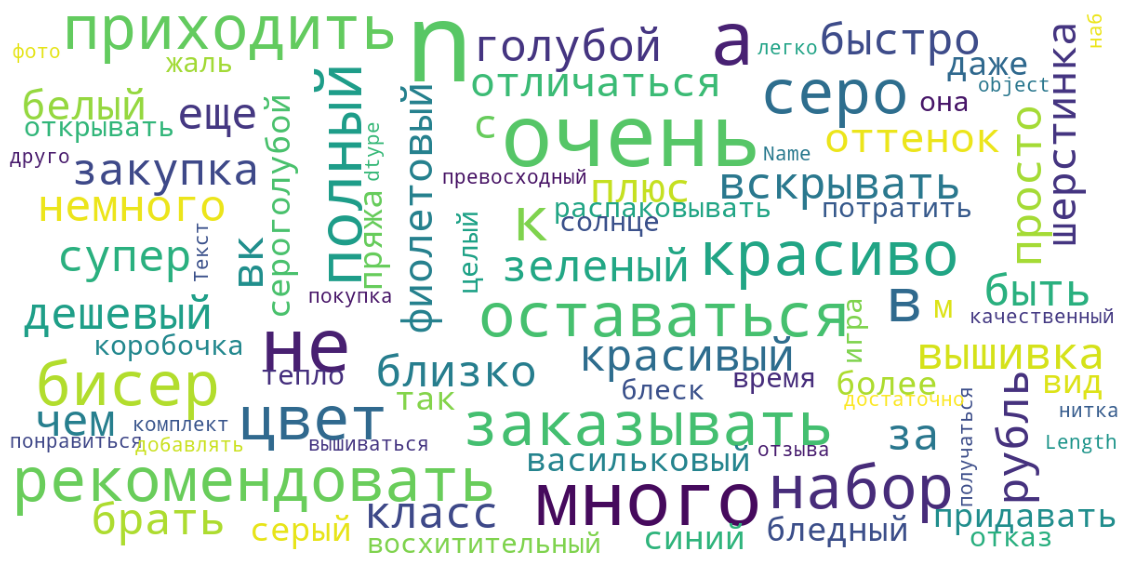

In [76]:
# функция для облака слов
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(data["Текст отзыва"])